https://www.quantstart.com/articles/State-Space-Models-and-the-Kalman-Filter/

# Pairs Trading Maths

For two series $y_{1,t}, y_{2,t}$ defined by  

$y_{1,t} \equiv \gamma x_t + \epsilon_{1,t}$ \
$y_{2,t} \equiv x_t + \epsilon_{2,t}$

where $x_t$ is a random walk common trend (i.e. $x_t - x_{t-1} = \epsilon_t$), we define the spead $z_t$ as

$z_t \equiv y_{1,t} - \gamma y_{2,t} = \gamma x_t + \epsilon_{1,t} - \gamma x_t + \gamma \epsilon_{2,t}$ \
$ z_t = \epsilon_{1,t} - \gamma \epsilon_{2,t}$

Because this spread is mean reverting and stationary for cointegrated time series, we write

$z_t = y_{1,t} - \gamma y_{2,t} \equiv \mu + \epsilon_t$. 

Rearranging gives, 

$y_{1,t} = \mu + \gamma y_{2,t} + \epsilon_t$

which is the typical form of a linear regression.

So what we are really looking for is $\epsilon_t$ to be stationary for $z_t$ to be stationary, i.i.d and hence mean reverting.

We need as good as as estimate for $\gamma$ as possible so that the spread is "as i.i.d. as possible", which will give the best/most mean reverting trading signals.

# Linear State-space Model

State equation: $\theta_t = G_t \theta_{t-1} + w_t$

Observation equation: $y_t = F^{T}_t \theta_t + v_t$

$\theta_0 \sim \mathcal{N} (m_0, C_0) \\
v_t \sim \mathcal{N} (0, V_t) \\
w_t \sim \mathcal{N} (0, W_t)
$

Rememeber we can never actually observe the hidden state $\theta_t$ as it is hidden by noise all we can do is predict what the observable variable of the system $y_t$. 

## Bayes Theorem to Kalman 

All the data known about the system at time $t$: $D_t = (D_{t-1}, y_t)$

So Bayes theroem becomes:

$P(\theta_t | D_t = (D_{t-1}, y_t)) = \frac{P(y_t | \theta_t) P(\theta_t | D_{t-1})}{P(y_t)}$

Prior: $P(y_t | \theta_t) \sim \mathcal{N}(F^{T}_t \theta_t, V_t)$ \
Liklihood: $P(\theta_t | D_{t-1}) \sim \mathcal{N}(a_t, R_t)$ \
Positerior: $ P(\theta_t | D_t) \sim \mathcal{N}(m_t, C_t)$

(Bear in mind that $a_t \rightarrow m_t$ in each update)

All quantities are guassian so the posterior probability distrinution is also guassian in a with a nice closed form which uses the Linear state-space model:

$
a_t = G_t m_{t-1} \\
R_t = G_t C_{t-1} G^{T}_t + W_t \\
e_t = y_t - f_t \quad \text{Error in the predicted observation}\\
m_t = a_t + A_t e_t \quad \text{Posterior mean is a weighted sum of the prior mean and the forecast error}\\
f_t = F^{T}_t a_t \quad \text{Predicted observation}\\
Q_t = F^{T}_t R_t F_t + V_t \quad \text{Variance in the predicted observation}\\
A_t = R_t F_t Q^{-1}_t \quad \text{Kalman Gain}\\
C_t = R_t - A_t Q_t A^{T}_t
$

# EM Update Equation (Not Currently Implemented)
$Q = \frac{1}{T-1} \sum_{t=0}^{T-2}
                (\mathbb{E}[x_{t+1}] - A_t \mathbb{E}[x_t] - b_t)
                    (\mathbb{E}[x_{t+1}] - A_t \mathbb{E}[x_t] - b_t)^T
                + A_t Var(x_t) A_t^T + Var(x_{t+1})
                - Cov(x_{t+1}, x_t) A_t^T - A_t Cov(x_t, x_{t+1})$
                
$R = \frac{1}{T} \sum_{t=0}^{T-1}
                [z_t - C_t \mathbb{E}[x_t] - b_t]
                    [z_t - C_t \mathbb{E}[x_t] - b_t]^T
                + C_t Var(x_t) C_t^T$

# Pairs Trading Application 

Linear regression in question: 
$y({\bf x}) = \beta^T {\bf x} + \epsilon$, with $\beta^T = (\mu_t, \gamma_t)$ and ${\bf x} = \begin{pmatrix} 1 \\ x \end{pmatrix}$.

## Reformulate as a state space model

Assume that $\mu_t$ and $\gamma_t$ follow random walks: 


1) $\beta_{t+1} ={\bf I} \beta_{t} + w_t, \quad$ (State Equation with $\theta_t = \beta^T_t$)

We can observe the price of both stocks to reveal more information about $\mu_t$ and $\gamma_t$. Specifically via the relation: 

2) $ y_t = (1, x_t ) \begin{pmatrix} \mu_t \\ \gamma_t \end{pmatrix} + v_t, \quad$ (Observation Equation)

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm

np.random.seed(0)

In [5]:
class Stock_Data_Fetcher():
    def __init__(self, stocks, start_date, end_date=None):
        self.stocks = stocks
        self.start_date = start_date
        self.end_date = end_date if end_date is not None else date.today().strftime('%Y-%m-%d')
        self.data = self.fetch_stock_data()

    def fetch_stock_data(self):
        data = yf.download(self.stocks, start=self.start_date, end=self.end_date)['Adj Close']
        return data
    
    def calculate_log_returns(self):
        log_returns = self.data.pct_change().dropna()
        self.log_returns = log_returns.apply(lambda x: np.log(1 + x))
        
    def draw_date_coloured_scatterplot(self, pair):
   
        # Create a yellow-to-red colourmap where yellow indicates
        # early dates and red indicates later dates
        plen = len(self.data)
        a, b = pair[0], pair[1]
        colour_map = plt.cm.get_cmap('YlOrRd')    
        colours = np.linspace(0.1, 1, plen)

        # Create the scatterplot object
        scatterplot = plt.scatter(
            self.data[a], self.data[b], 
            s=30, c=colours, cmap=colour_map, 
            edgecolor='k', alpha=0.8
        )

        # Add a colour bar for the date colouring and set the 
        # corresponding axis tick labels to equal string-formatted dates
        colourbar = plt.colorbar(scatterplot)
        colourbar.ax.set_yticklabels(
            [str(p.date()) for p in self.data[::plen//9].index]
        )
        plt.grid()
        plt.xlabel(self.data.columns[0])
        plt.ylabel(self.data.columns[1])
        plt.show()
    


In [6]:
class Trade():
    def __init__(self, value, position, start_date):
        self.history, self.position = [value], position
        self.start_date = start_date
        self.closed = False
        self.trade_return = None
 
    def hold(self, value):
        assert not self.closed, "Trade is already closed. No further modifications allowed."
        self.history.append(value)
        
    def close(self, value=0):
        assert not self.closed, "Trade is already closed."
        self.history.append(value)
        self.closed = True
       
    def analyse(self):
        assert self.closed, "Trade is not closed. Cannot analyse."
        self.calc_return()
  
    def calc_return(self):
        self.trade_return = self.position * (self.history[-1] - self.history[0])
        
        
    def __bool__(self):
        return self.closed
    
class Trade_Logger():
    def __init__(self):
        self.history = []
        
    def log(self, trade):
        if trade:
            self.history.append(trade)
        else:
            raise ValueError("Trade is not closed. Cannot log.")
        
    def generate_trade_stats(self):
        trade_stats = {'total_return': 0}
        for trade in self.history:
            trade.analyse()
            trade_stats['total_return'] += trade.trade_return
        return trade_stats

In [7]:
class Kalman_Pairs_Trader():
    def __init__(self, df, pair, w_t_init_list, v_t_init, split_date=None):
        self.df = df[pair]
        if split_date is not None: 
            split_date = pd.to_datetime(split_date)
            self.df_train = self.df[df.index < split_date]
            self.df_test = self.df[df.index >= split_date]
        else:
            self.df_train = self.df_test = self.df
        
        # Trade data
        self.stock_a, self.stock_b = pair[0], pair[1]
        self.trade_logger = Trade_Logger()
        self.trade = None
        self.positions = pd.Series(index=df.index, dtype=float)
        self.zs = pd.Series(index=df.index, dtype=float)
    
        # Noise params. 
        self.w_t = w_t_init_list * np.eye(2)
        self.v_t = v_t_init
        self.burn_in = 30
        self.w_gamma = pd.Series(index=df.index, dtype=float)
        self.w_mu = pd.Series(index=df.index, dtype=float)
        self.v_ts = pd.Series(index=df.index, dtype=float)

        # Latent state space model
        self.theta = np.array([1.0, 0.0])
        self.P = np.zeros((2, 2))
        self.R = None
        self.C = None
        # To track over time
        self.threshold = self.v_t # initial guess from update equations? 
        self.gammas = pd.Series(index=df.index, dtype=float)
        self.thresholds = pd.Series(index=df.index, dtype=float)
        self.mus = pd.Series(index=df.index, dtype=float)
        
        # For noise updates.
        self.delta_gammas = pd.Series(index=df.index, dtype=float)
        self.delta_mus = pd.Series(index=df.index, dtype=float)
        self.prediction_errors = pd.Series(index=df.index, dtype=float)
        self.post_run_df = None
        
    def run(self):
        
        position = 0
        self.burn_in_time = self.df.index[0] + pd.DateOffset(days=self.burn_in)
        
        for i, (t, stock_prices) in enumerate(df.iterrows()):
            self.thresholds[t] = self.threshold
            self.gammas[t] = self.theta[0]
            self.mus[t] = self.theta[1]
            z = stock_prices[0] - self.theta[0] * stock_prices[1]
            self.zs[t] = z
            
            if t < self.burn_in_time:
                self.positions[t] = 0
            else:
                position = self.calc_position(t, position, z)
                self.positions[t] = position
            
            self.w_gamma[t] = self.w_t[0,0]
            self.w_mu[t] = self.w_t[1,1]
            self.v_ts[t] = self.v_t
            
            # Update everything within kalman_step
            self.kalman_step(t, i, stock_prices)
            
        
        self.generate_post_run_df()
            
      
    def kalman_step(self, t, i, stock_prices):
        # Apply the above update equations with G=I
        price_a, price_b = stock_prices
        F = np.asarray([price_b, 1]).reshape((1, 2))
        y = price_a

        if self.R is not None:
            self.R = self.C + self.w_t 
        else:
            self.R = np.zeros((2, 2))

        # Predict.
        yhat = F.dot(self.theta)
        e_t = y - yhat
        Q_t = F.dot(self.R).dot(F.T) + self.v_t
        self.threshold = np.sqrt(Q_t).item()
        
        # Update.
        A_t = self.R.dot(F.T) / Q_t
        old_theta = self.theta
        new_theta = old_theta + A_t.flatten() * e_t
        theta_delta = old_theta - new_theta
        self.theta = new_theta
        
        old_C = self.C
        new_C = self.R - A_t * F.dot(self.R)
        self.C = new_C
        
        self.delta_gammas[t] = theta_delta[0]
        self.delta_mus[t] = theta_delta[1]
        self.prediction_errors[t] = e_t
        
#         # Noise params
#         if i > self.burn_in:
#             temp = np.array([self.rolling_var(self.delta_gammas[burn_in_time:t]), self.rolling_var(self.delta_mus[burn_in_time:t])]) * np.eye(2)
#             self.w_t = temp + new_C - old_C
# #             self.v_t = self.rolling_var(self.prediction_errors[burn_in_time:t]) + F.dot(new_C.dot(F.T)) - F.dot(old_C.dot(F.T))
# #             self.v_t = self.prediction_errors[burn_in_time:t].min() + F.dot(new_C.dot(F.T)) - F.dot(old_C.dot(F.T))
            
    
    @staticmethod
    def rolling_var(series):
        return (series**2).sum()/len(series)
        
    
    def calc_position(self, t, position, z):  
        max_thr = self.theta[1] + self.threshold 
        min_thr = self.theta[1] - self.threshold
        # Run the logic.
        if position == 0:
            if z >= max_thr:
                position = -1
                self.trade = Trade(max_thr, position, t)
            elif z <= min_thr:
                position = 1
                self.trade = Trade(min_thr, position, t)
            else:
                position = 0

        elif position == -1:
            if min_thr < z < 0:
                self.trade.close()
                self.trade_logger.log(self.trade)
                position = 0
            elif z <= min_thr:
                self.trade.close()
                self.trade_logger.log(self.trade)
                position = 1
                self.trade = Trade(min_thr, position, t)
            else:
                self.trade.hold(z)

        elif position == 1:
            if 0 < z < max_thr:
                self.trade.close()
                self.trade_logger.log(self.trade)
                position = 0
            elif z >= max_thr:
                self.trade.close()
                self.trade_logger.log(self.trade)
                position = -1
                self.trade = Trade(max_thr, position, t)
            else:
                self.trade.hold(z)
        
        return position
    
    def generate_post_run_df(self):
        self.post_run_df = pd.DataFrame({'z': self.zs, 
                                         'threshold': self.thresholds, 
                                         'mu': self.mus,
                                         'gamma':self.gammas,
                                         'error': self.prediction_errors,
                                         'position': self.positions})
    def analyse(self):
        self.trade_stats = self.trade_logger.generate_trade_stats()
        return self.trade_stats
    
    def plot(self, split_date=None):
        fig, ax = plt.subplots(figsize=(12,4), nrows=2, ncols=1)

        ax[0].plot(self.post_run_df['z'][3:], c='b', lw=0.7)
        ax[0].plot(self.post_run_df['mu'][3:] + self.post_run_df['threshold'][3:], 
                   color='g', linestyle='--', lw=1)
        ax[0].plot(self.post_run_df['mu'][3:] - self.post_run_df['threshold']
                   , 
                   color='g', linestyle='--', lw=1)
        
        ax[0].plot(self.post_run_df['mu'][3:],  linestyle='--', lw=1)
        
        ax[0].set_ylabel('Spread', color='b')
        ax[0].tick_params(axis='y', colors='b')
        ax[1].plot(self.post_run_df['position'], c='red', lw=0.5)
        ax[1].set_ylabel('Position', color='red')
        ax[0].grid()
        ax[1].grid()
        if split_date is not None:
            ax[0].axvline(x=split_date, c='red', lw=1)
            ax[1].axvline(x=split_date, c='red', lw=1)
            
        plt.show()
    

In [8]:
stocks = ['TLT', 'IEI']
# stocks = ['JPY=X', 'GBPJPY=X']
start_date = '2023-01-01'
end_date = None


fetcher = Stock_Data_Fetcher(stocks, start_date, end_date)
fetcher.calculate_log_returns()
# df = fetcher.log_returns
df = fetcher.data

[*********************100%***********************]  2 of 2 completed


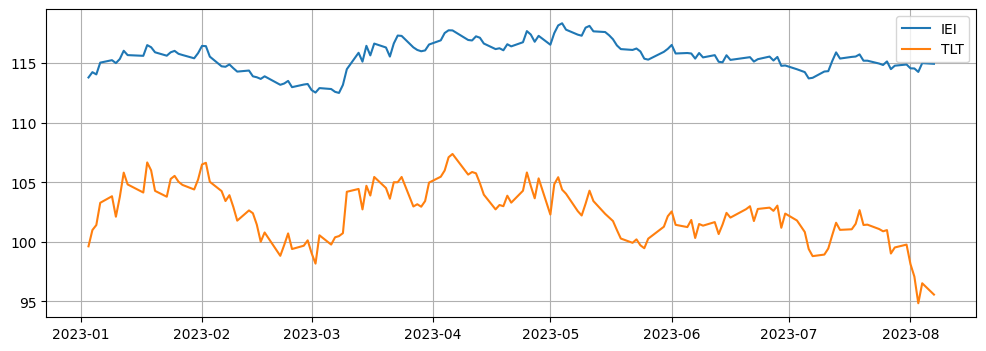

In [9]:
fig, ax = plt.subplots(figsize=(12,4),nrows=1, ncols=1, sharex=True )
ax.plot(df, label=df.columns)
ax.grid()
ax.legend();

C:\Users\adamm\AppData\Local\Temp\ipykernel_3872\1837859606.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  colourbar.ax.set_yticklabels(


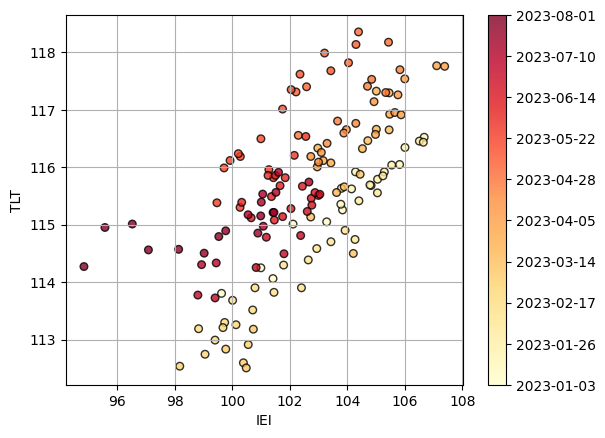

In [10]:
fetcher.draw_date_coloured_scatterplot(stocks)

# Determine Noise Hyper-Parameters With a Grid Search

In [11]:
split_date = pd.to_datetime('2023-04-01')

wt_gammas = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
wt_mus = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
vt_mus = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

tot_returns_before = np.zeros((len(wt_gammas),len(wt_mus), len(vt_mus)))
tot_returns_after = np.zeros((len(wt_gammas),len(wt_mus), len(vt_mus)))
noise_df_gamma = pd.DataFrame(index=df.index)
noise_df_mu = pd.DataFrame(index=df.index)
for i, wt_gamma in enumerate(wt_gammas):
    for j, wt_mu in enumerate(wt_mus):
        for k, vt in enumerate(vt_mus):
            trader = Kalman_Pairs_Trader(df, stocks, [wt_gamma, wt_mu], vt)
            trader.run()
            analysis = trader.analyse()
            tot_returns_before[i][j][k] = sum(trade.trade_return for trade in trader.trade_logger.history if trade.start_date < split_date)
            tot_returns_after[i][j][k] = sum(trade.trade_return for trade in trader.trade_logger.history if trade.start_date > split_date)

            noise_df_gamma[f"{wt_gamma},{wt_mu}"] = trader.w_gamma
            noise_df_mu[f"{wt_gamma},{wt_mu}"] = trader.w_mu

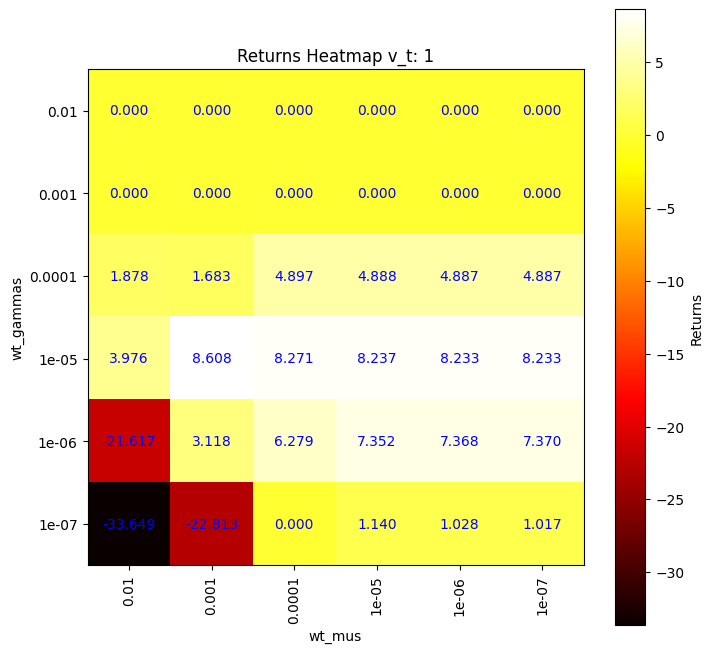

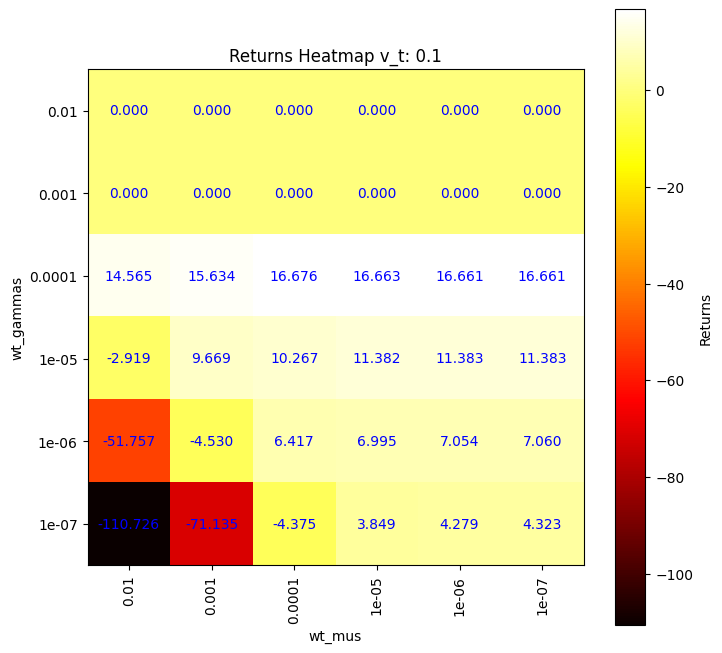

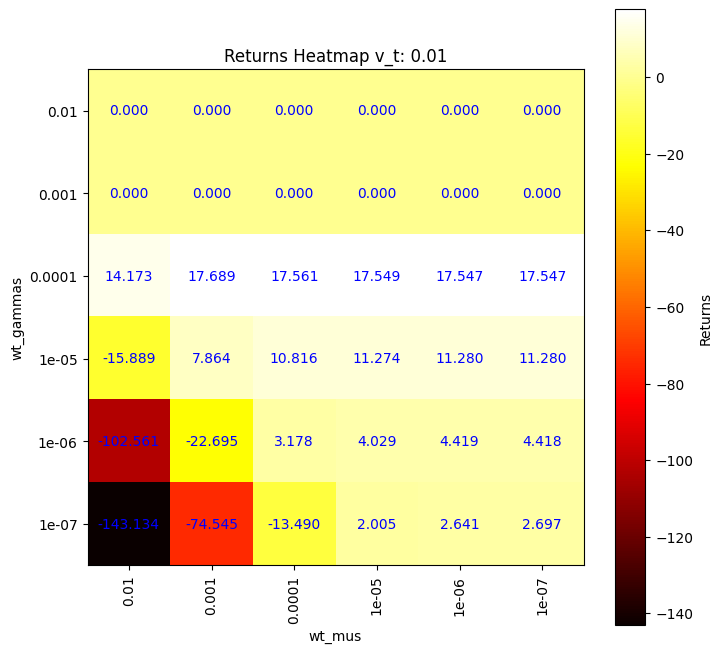

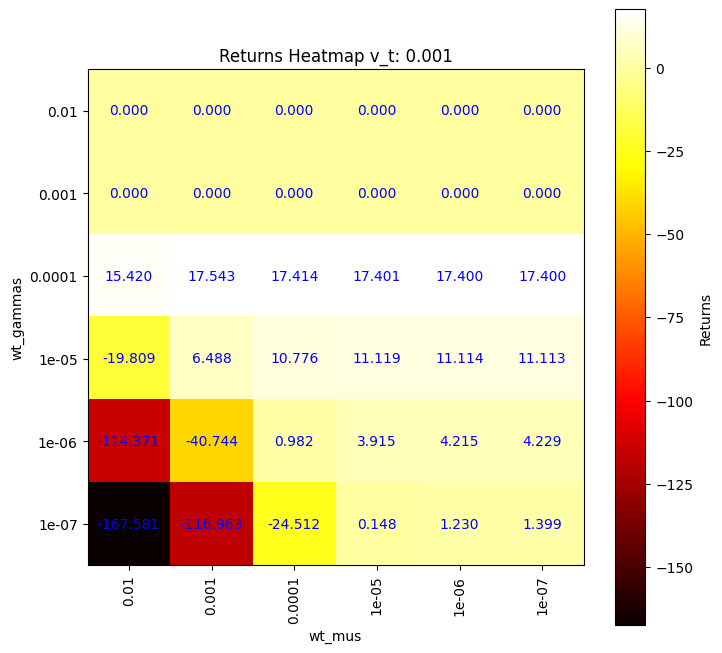

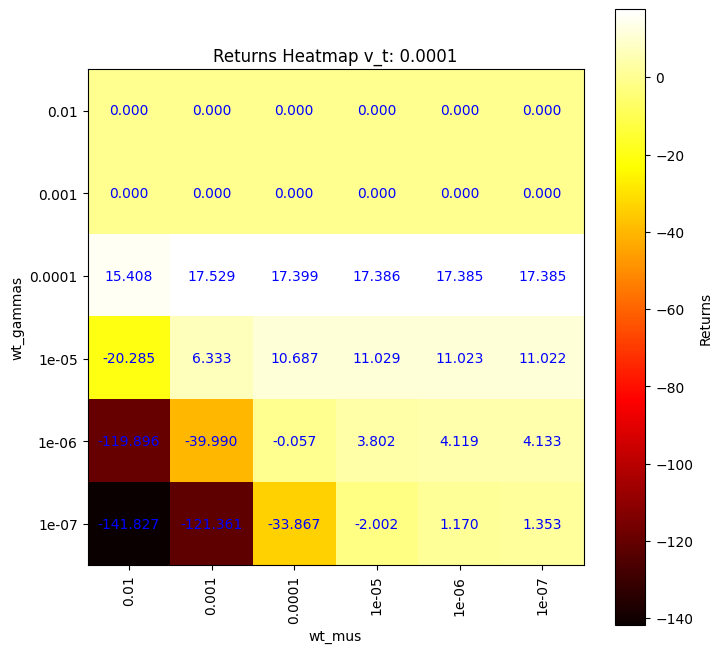

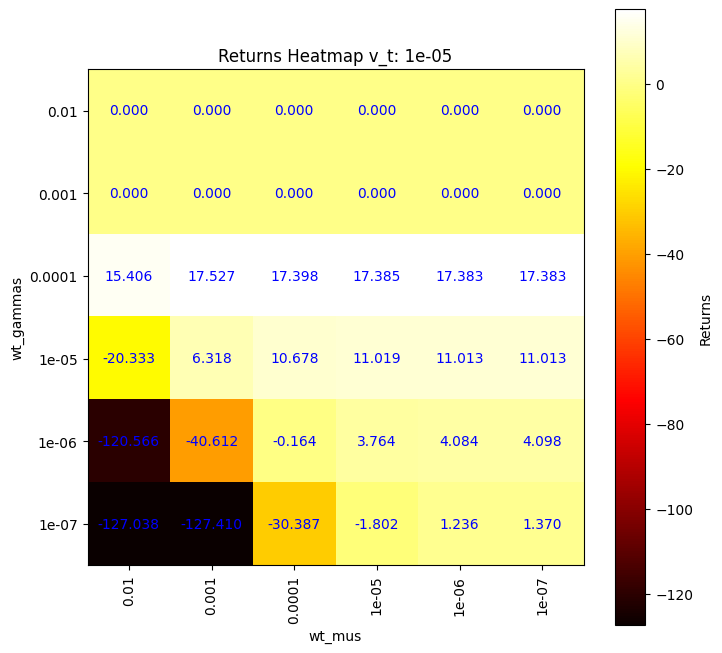

In [52]:
r = tot_returns_after
for k, vt in enumerate(vt_mus):
    fig, ax = plt.subplots(figsize=(8, 8))
    heatmap = ax.imshow(r[:,:,k], cmap='hot', interpolation='nearest')

    # Set x and y axis labels
    ax.set_xticks(np.arange(len(wt_mus)))
    ax.set_yticks(np.arange(len(wt_gammas)))
    ax.set_xticklabels(wt_mus, rotation='vertical')
    ax.set_yticklabels(wt_gammas)

    for i in range(len(wt_gammas)):
        for j in range(len(wt_mus)):
            text = ax.text(j, i, '{:.3f}'.format(r[i, j, k]),
                           ha='center', va='center', color='b')

    # Set colorbar
    cbar = plt.colorbar(heatmap)
    cbar.set_label('Returns')

    # Set plot title and labels
    ax.set_title(f'Returns Heatmap v_t: {vt}')
    ax.set_xlabel('wt_mus')
    ax.set_ylabel('wt_gammas')

    # Show the plot
    plt.show()

# Check the Normality + PACF + ACF of Spread In Training Period

In [53]:
wt_gamma = 1e-04
wt_mu = 1e-04
vt = 1e-1
trader = Kalman_Pairs_Trader(df, stocks, [wt_gamma, wt_mu], vt)
# trader = Kalman_Pairs_Trader(df, stocks, [wt_gam, wt_m], v_t)
trader.run()
trade_ts_df = trader.post_run_df 

In [54]:
train_period = trade_ts_df[(trader.burn_in_time < trade_ts_df.index) & (trade_ts_df.index < split_date)]
train_period.describe()
# looking for std of z and threshold mean to match roughly

,z,threshold,mu,gamma,error,position
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.052952,1.113489,0.001919,1.120059,0.051032,-0.025000
std,0.963710,0.020700,0.000470,0.012634,0.963829,0.422902
min,-2.551223,1.074178,0.001069,1.091977,-2.553193,-1.000000
25%,-0.489206,1.096111,0.001584,1.112418,-0.491439,0.000000
50%,0.076894,1.117054,0.001948,1.120466,0.074397,0.000000
75%,0.846053,1.131144,0.002300,1.128804,0.844781,0.000000
max,1.760878,1.153273,0.002728,1.145466,1.758486,1.000000


Shapiro p-val 0.162704, Not normal


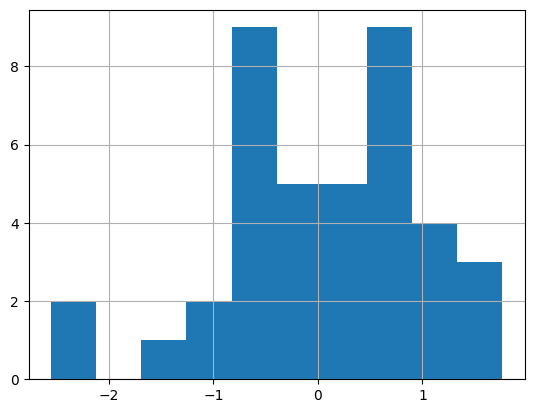

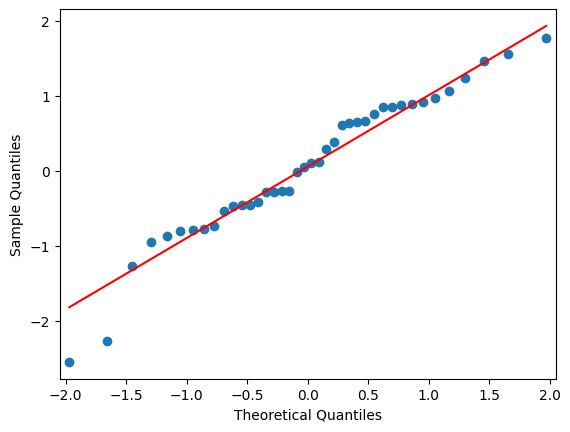

In [55]:
statistic, p_value = shapiro(train_period['z'])
result = 'Normal' if p_value < 0.05 else 'Not normal'
train_period['z'].hist()
qqplot(train_period['z'], line='s');
print(f"Shapiro p-val {p_value:.6f}, {result}")

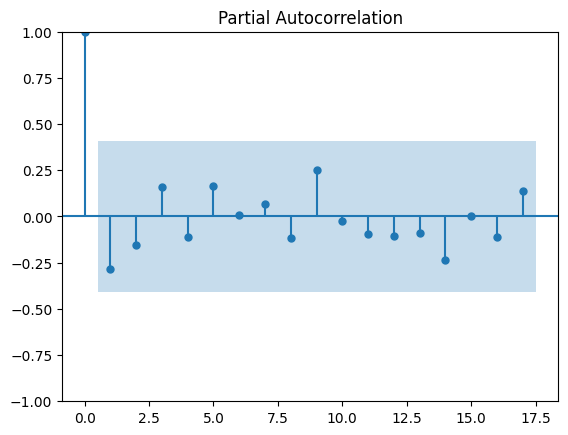

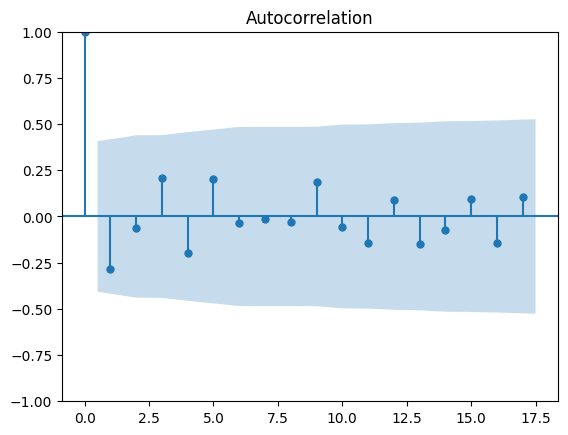

In [56]:
sm.graphics.tsa.plot_pacf(train_period['z'], alpha=0.01);
sm.graphics.tsa.plot_acf(train_period['z'], alpha=0.01);

In [57]:
ar1 = sm.tsa.arima.ARIMA(train_period['z'], order=(1, 0, 0))
ma1 = sm.tsa.arima.ARIMA(train_period['z'], order=(0, 0, 1))
zar1 = ar1.fit()
zma1 = ma1.fit()
print(zar1.summary())
print(zma1.summary())

                               SARIMAX Results                                
Dep. Variable:                      z   No. Observations:                   40
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -52.991
Date:                Tue, 08 Aug 2023   AIC                            111.982
Time:                        18:33:55   BIC                            117.049
Sample:                             0   HQIC                           113.814
                                 - 40                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0561      0.122      0.459      0.646      -0.183       0.295
ar.L1         -0.2980      0.230     -1.294      0.196      -0.749       0.153
sigma2         0.8264      0.174      4.741      0.0

C:\Users\adamm\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\adamm\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\adamm\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\adamm\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been pro

# Now Look at The Test Results

In [58]:
test_period = trade_ts_df[trade_ts_df.index > split_date]
analysis = trader.analyse()
after_trades = [trade for trade in trader.trade_logger.history if trade.start_date > split_date]
tot_return = sum(trade.trade_return for trade in after_trades)
n_trades = len(after_trades)
mean_trade_return = tot_return/n_trades

# Trades: 15| Mean Return (price) 1.112| Tot. Return (price) 16.676


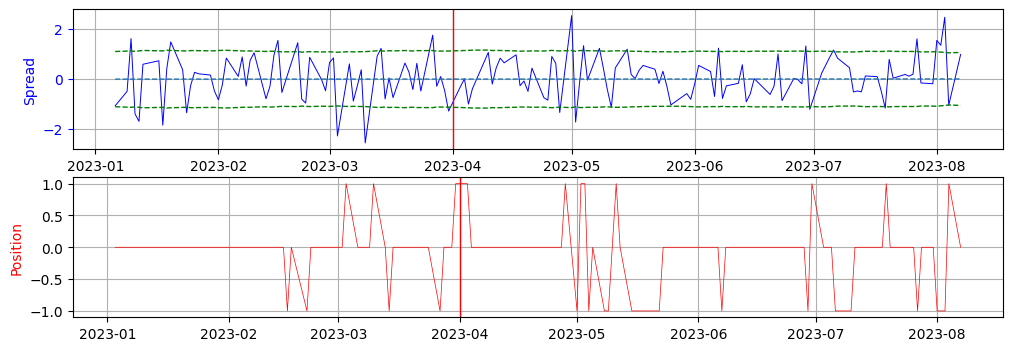

In [59]:
print(f"# Trades: {n_trades}| Mean Return (price) {mean_trade_return:.3f}| Tot. Return (price) {tot_return:.3f}")
trader.plot(split_date)

# See if Normality + ARIMA(0,0,0) Held

Shapiro p-val 0.294876, Not normal


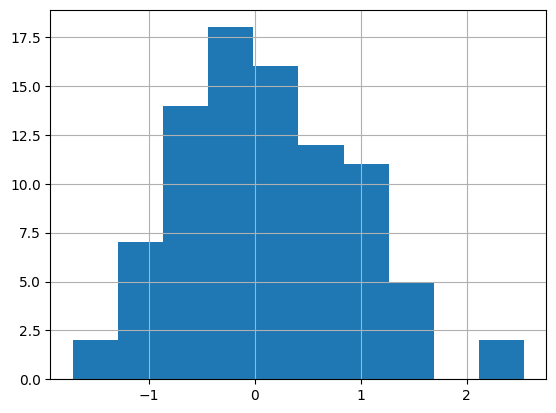

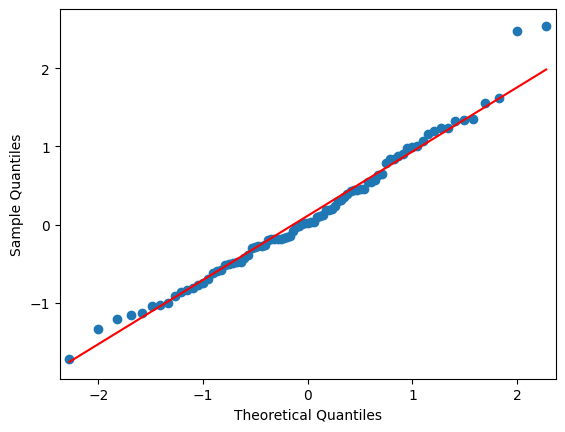

In [60]:
statistic, p_value = shapiro(test_period['z'])
result = 'Normal' if p_value < 0.05 else 'Not normal'
test_period['z'].hist()
qqplot(test_period['z'], line='s');
print(f"Shapiro p-val {p_value:.6f}, {result}")

In [61]:
ar1 = sm.tsa.arima.ARIMA(test_period['z'], order=(1, 0, 0))
ma1 = sm.tsa.arima.ARIMA(test_period['z'], order=(0, 0, 1))
zar1 = ar1.fit()
zma1 = ma1.fit()
print(zar1.summary())
print(zma1.summary())

                               SARIMAX Results                                
Dep. Variable:                      z   No. Observations:                   87
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -105.641
Date:                Tue, 08 Aug 2023   AIC                            217.282
Time:                        18:34:11   BIC                            224.680
Sample:                             0   HQIC                           220.261
                                 - 87                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1145      0.085      1.351      0.177      -0.052       0.281
ar.L1         -0.1173      0.087     -1.350      0.177      -0.288       0.053
sigma2         0.6640      0.104      6.394      0.0

C:\Users\adamm\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\adamm\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\adamm\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\adamm\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been pro